In [2]:
import pandas as pd
import numpy as np
import cv2
import math

In [3]:
def findCenterAndOrientation(src):
    M = cv2.moments(src)
    cen_x = M["m10"]/M["m00"];
    cen_y = M["m01"]/M["m00"];
    theta = 0.5 * math.atan2( 2*M["mu11"], M["mu20"]-M["mu02"]);
    
    return cen_x, cen_y, theta

In [4]:
img = cv2.imread('Arborio (2).jpg', 0)

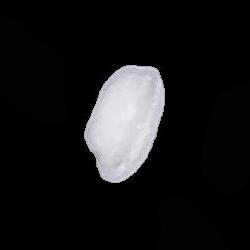

In [5]:
from IPython.display import Image

Image(filename='Arborio (2).jpg') 

In [6]:
x, y, theta = findCenterAndOrientation(img)
ponto = (x,y)

In [7]:
angulo = 180*theta/math.pi
rotacao = cv2.getRotationMatrix2D(ponto, angulo, 1.0)
rotacionado = cv2.warpAffine(img, rotacao, (len(img[0]), len(img[1])))

In [8]:
cv2.imwrite('white_shape_centered.png',rotacionado)

True

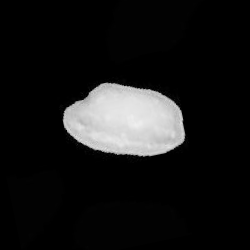

In [9]:
Image(filename='white_shape_centered.png') 